In [54]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Sett korrekt sti til Excel-filen din
SRC = Path("leie_priser.xlsx")  # endre hvis den ligger et annet sted
assert SRC.exists(), f"Fant ikke filen: {SRC.resolve()}"


In [55]:
#Read data from Excel file
data = pd.read_excel(SRC, sheet_name=0)
print("Innhold i Excel-filen:")
print(data.head())

Innhold i Excel-filen:
                                             Omr√•de      St√∏rrelse  2012  \
0  Oslo - Sentrum, Frogner, Ullern og St.Hanshaugen  1-roms 15 kvm  6920   
1  Oslo - Sentrum, Frogner, Ullern og St.Hanshaugen  1-roms 20 kvm  7210   
2  Oslo - Sentrum, Frogner, Ullern og St.Hanshaugen  1-roms 30 kvm  7640   
3  Oslo - Sentrum, Frogner, Ullern og St.Hanshaugen  1-roms 40 kvm  7960   
4  Oslo - Sentrum, Frogner, Ullern og St.Hanshaugen  1-roms 50 kvm  8220   

   2013  2014   2015   2016   2017   2018   2019   2020   2021   2022   2023  \
0  6800  6700   7000   7100   7300   7500   7600   7900   8000   8400   9300   
1  7200  7300   7600   7700   8000   8200   8400   8700   8700   9100  10100   
2  7900  8200   8600   8700   9000   9400   9600   9900   9800  10300  11300   
3  8500  9000   9300   9500   9900  10300  10600  10900  10600  11100  12300   
4  8900  9600  10000  10200  10600  11000  11400  11700  11400  11900  13100   

    2024  
0  10300  
1  11100  
2  1

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Omr√•de     400 non-null    object
 1   St√∏rrelse  400 non-null    object
 2   2012       400 non-null    int64 
 3   2013       400 non-null    int64 
 4   2014       400 non-null    int64 
 5   2015       400 non-null    int64 
 6   2016       400 non-null    int64 
 7   2017       400 non-null    int64 
 8   2018       400 non-null    int64 
 9   2019       400 non-null    int64 
 10  2020       400 non-null    int64 
 11  2021       400 non-null    int64 
 12  2022       400 non-null    int64 
 13  2023       400 non-null    int64 
 14  2024       400 non-null    int64 
dtypes: int64(13), object(2)
memory usage: 47.0+ KB


In [57]:
print(data.isna().sum())
#No NAN values found

Omr√•de       0
St√∏rrelse    0
2012         0
2013         0
2014         0
2015         0
2016         0
2017         0
2018         0
2019         0
2020         0
2021         0
2022         0
2023         0
2024         0
dtype: int64


In [58]:
#Finding columns containing the years 2012-2024
√•r_kolonner = [
    kol for kol in data.columns
    if re.fullmatch(r"\d{4}", str(kol)) and 2012 <= int(kol) <= 2024
]
if not √•r_kolonner:
    raise ValueError("Fant ingen √•rstallskolonner (2012-2024) i Excel-filen!")
#Make data into long format
long_df = data.melt(
    id_vars=["Omr√•de", "St√∏rrelse"],
    value_vars=√•r_kolonner,
    var_name="√•r",
    value_name="leiepris"
)
#Transform years to int and leiepris to numeric, drop NaNs
long_df["√•r"] = long_df["√•r"].astype(int)
long_df["leiepris"] = pd.to_numeric(long_df["leiepris"], errors="coerce")
long_df = long_df.dropna(subset=["leiepris"])


def split_st√∏rrelse_column(df, col_name="st√∏rrelse"):
    # Extract first value as integer into a column called rom
    df["rom"] = df[col_name].str.extract(r'(\d+)-roms').astype(int)
    
    # Extract size in square meters into a column called st√∏rrelse_m2
    df["st√∏rrelse_m2"] = df[col_name].str.extract(r'(\d+)\s*kvm').astype(int)
    
    return df

long_df = split_st√∏rrelse_column(long_df, col_name="St√∏rrelse")

In [59]:
long_df.head()

Omr√•de      St√∏rrelse    √•r  \
0  Oslo - Sentrum, Frogner, Ullern og St.Hanshaugen  1-roms 15 kvm  2012   
1  Oslo - Sentrum, Frogner, Ullern og St.Hanshaugen  1-roms 20 kvm  2012   
2  Oslo - Sentrum, Frogner, Ullern og St.Hanshaugen  1-roms 30 kvm  2012   
3  Oslo - Sentrum, Frogner, Ullern og St.Hanshaugen  1-roms 40 kvm  2012   
4  Oslo - Sentrum, Frogner, Ullern og St.Hanshaugen  1-roms 50 kvm  2012   

   leiepris  rom  st√∏rrelse_m2  
0      6920    1            15  
1      7210    1            20  
2      7640    1            30  
3      7960    1            40  
4      8220    1            50

In [ ]:
# Features og target
FEATURES_CATEGORICAL = ["Omr√•de"]
FEATURES_NUMERICAL = ["√•r", "rom", "st√∏rrelse_m2"]
TARGET = "leiepris"

X = long_df[FEATURES_CATEGORICAL + FEATURES_NUMERICAL]
y = long_df[TARGET]

# Filter training data on years before 2024, validation data on 2024
train_filter = long_df["√•r"] < 2024
val_filter   = long_df["√•r"] == 2024

X_train = X[train_filter]
y_train = y[train_filter]
X_val   = X[val_filter]
y_val   = y[val_filter]
X_copy = X.copy()

# One-hot encoding for categorical features
X_train = pd.get_dummies(X_train, columns=FEATURES_CATEGORICAL)
X_val   = pd.get_dummies(X_val, columns=FEATURES_CATEGORICAL)
X_copy = pd.get_dummies(X_copy, columns=FEATURES_CATEGORICAL)

X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
# Align columns of validation set to training set
feature_columns = X_train.columns.tolist()
# Makes sure y is float
y_train = y_train.astype(float)
y_val   = y_val.astype(float)

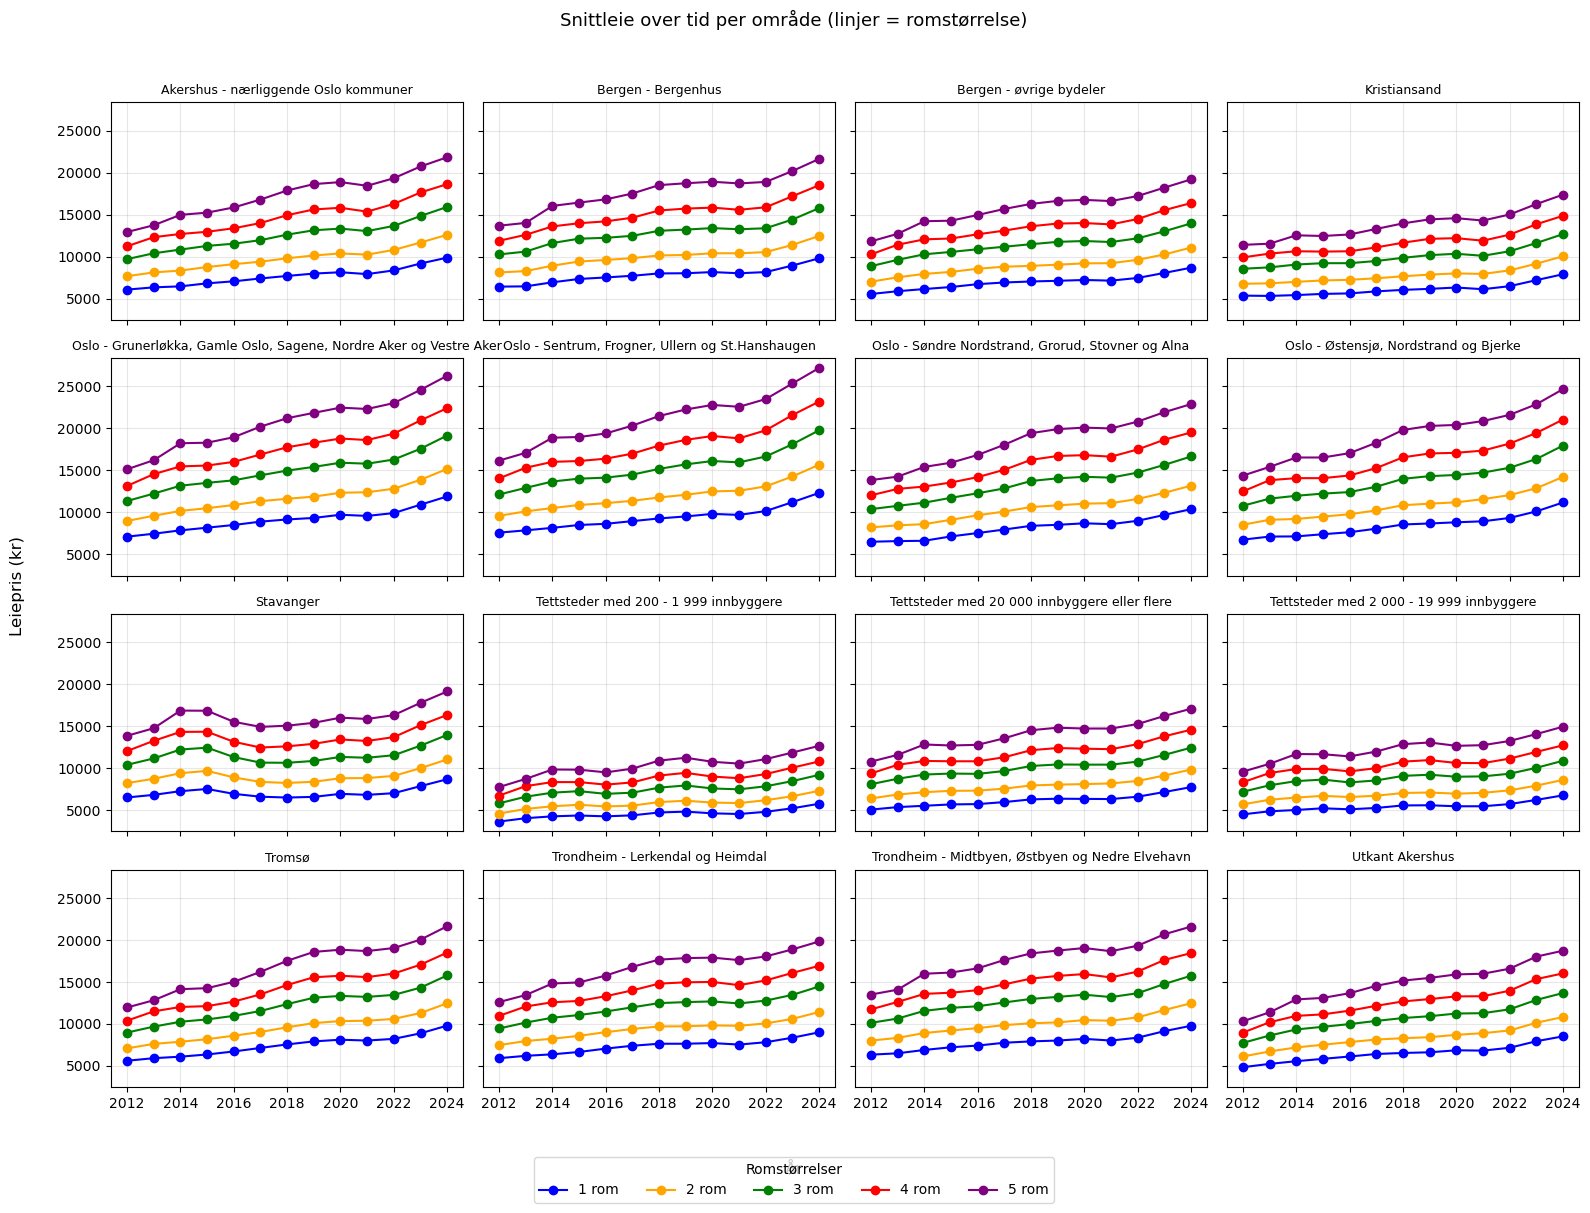

In [61]:
import math

#Prepare data for plotting
df_plot = (
    long_df
    .groupby(["Omr√•de", "√•r", "rom"], as_index=False)["leiepris"]
    .mean()
)

omr√•der = sorted(df_plot["Omr√•de"].unique())
n = len(omr√•der)


COLS = 4
ROWS = math.ceil(n / COLS)
fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS*4, ROWS*3), sharex=True, sharey=True)
axes = np.atleast_2d(axes)

farger = {1:"blue", 2:"orange", 3:"green", 4:"red", 5:"purple"} 


for i, omr√•de in enumerate(omr√•der):
    r, c = divmod(i, COLS)
    ax = axes[r, c]
    sub = df_plot[df_plot["Omr√•de"] == omr√•de]

    for rom in sorted(sub["rom"].unique()):
        ss = sub[sub["rom"] == rom].sort_values("√•r")
        ax.plot(ss["√•r"], ss["leiepris"], marker="o",
                label=f"{rom} rom", color=farger.get(rom, "gray"))

    ax.set_title(omr√•de, fontsize=9)
    ax.grid(True, alpha=0.3)


for j in range(n, ROWS*COLS):
    r, c = divmod(j, COLS)
    axes[r, c].axis("off")


rom_labels = [f"{r} rom" for r in sorted(df_plot["rom"].unique())]
rom_colors = [farger.get(r, "gray") for r in sorted(df_plot["rom"].unique())]
handles = [plt.Line2D([0], [0], color=rom_colors[i], marker='o') for i in range(len(rom_labels))]
fig.legend(handles, rom_labels, title="Romst√∏rrelser", loc="lower center",
           ncol=len(rom_labels), bbox_to_anchor=(0.5, -0.02))


fig.suptitle("Snittleie over tid per omr√•de (linjer = romst√∏rrelse)", fontsize=13)
fig.text(0.5, 0.01, "√Ör", ha="center", fontsize=12)
fig.text(0.01, 0.5, "Leiepris (kr)", va="center", rotation="vertical", fontsize=12)

plt.tight_layout(rect=[0.03, 0.05, 1, 0.96])
plt.show()



In [62]:
import joblib

# Valide rom per omr√•de
rom_per_omr√•de = (long_df.dropna(subset=["rom"])
                  .groupby("Omr√•de")["rom"]
                  .unique().apply(lambda x: sorted(set(int(r) for r in x)))
                  .to_dict())

# Valid square meters per omr√•de og rom
m2_per_omr√•de_rom = (long_df.dropna(subset=["rom","st√∏rrelse_m2"])
                     .groupby(["Omr√•de","rom"])["st√∏rrelse_m2"]
                     .unique().apply(lambda x: sorted(set(int(v) for v in x)))
                     .to_dict())

joblib.dump(rom_per_omr√•de, "rom_per_omr√•de.pkl")
joblib.dump(m2_per_omr√•de_rom, "m2_per_omr√•de_rom.pkl")



['m2_per_omr√•de_rom.pkl']

In [63]:
from sklearn.ensemble import GradientBoostingRegressor

model_p50 = GradientBoostingRegressor(loss="quantile", alpha=0.5, random_state=42)

model_p50.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.5, loss='quantile', random_state=42)

In [64]:
from sklearn.metrics import mean_absolute_error

pred_val = model_p50.predict(X_val)
mae = mean_absolute_error(y_val, pred_val)
print(f"GRBR Validation MAE (2024): {mae:,.0f} kr")



GRBR Validation MAE (2024): 1,816 kr


In [65]:
from sklearn.metrics import  mean_squared_error, r2_score,mean_absolute_error,median_absolute_error
model_p50.fit(X_train, y_train)

mae = mean_absolute_error(y_val, pred_val)
rmse = np.sqrt(mean_squared_error(y_val, pred_val))
r2 = r2_score(y_val, pred_val)

print(f"GBRegressor Evaluation (2024):")
print(f"MAE  = {mae:,.0f} kr")
print(f"RMSE = {rmse:,.0f} kr")
print(f"R¬≤   = {r2:.3f}")


GBRegressor Evaluation (2024):
MAE  = 1,816 kr
RMSE = 2,389 kr
R¬≤   = 0.769


In [66]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=600,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    tree_method="hist"
)

xgb.fit(X_train, y_train)

pred_val = xgb.predict(X_val)
mae = mean_absolute_error(y_val, pred_val)
r2  = r2_score(y_val, pred_val)
print(f"XGBoost - 2024: MAE {mae:,.0f} kr | R¬≤ {r2:.3f}")

#HMM to good model, suspicious?

XGBoost - 2024: MAE 1,016 kr | R¬≤ 0.954


In [67]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

tscv = TimeSeriesSplit(n_splits=5)  # Split by years
param_grid = {'n_estimators': [200, 400, 600], 'max_depth': [3,4, 5,6,7,8,9,10], 'learning_rate': [0.01, 0.05, 0.1]}
grid_search = GridSearchCV(XGBRegressor(random_state=42), param_grid, cv=tscv, scoring='neg_mean_absolute_error', verbose=1)
grid_search.fit(X_copy, y)  # Use full data for CV
xgb_p50 = grid_search.best_estimator_
print(f"Best params: {grid_search.best_params_}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 600}


In [68]:
param_grid = {
    'n_estimators': [600],            # from previous tuning
    'max_depth': [3],                 # from previous tuning
    'learning_rate': [0.1],           # from previous tuning
    'subsample': [0.7, 0.8, 1.0],     # NEW
    'colsample_bytree': [0.7, 0.9, 1.0],  # NEW
    'reg_lambda': [0, 1.0, 10, 50],   # NEW
    'reg_alpha': [0, 0.1, 1]          # NEW
}
grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best MAE for 2023:", -grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best params: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 600, 'reg_alpha': 1, 'reg_lambda': 0, 'subsample': 0.7}
Best MAE for 2023: 664.7766684570313


In [69]:
xgb = XGBRegressor(
    n_estimators=5000,          # large cap; ES will stop earlier
    learning_rate=0.03,
    max_depth=3,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_lambda=10,              # stronger L2
    reg_alpha=2,                # stronger L1
    min_child_weight=5,         # require more data per leaf
    gamma=1,                    # require gain to split
    random_state=42,
    tree_method="hist"
)

xgb.fit(
    X_train, y_train)

pred_val = xgb.predict(X_val)
print(
    "MAE", f"{mean_absolute_error(y_val, pred_val):,.0f}",
    "| RMSE", f"{np.sqrt(mean_squared_error(y_val, pred_val)):,.0f}",
    "| R¬≤", f"{r2_score(y_val, pred_val):.3f}"
)


MAE 1,016 | RMSE 1,075 | R¬≤ 0.953


In [70]:
pred_train = xgb.predict(X_train)
mae_train = mean_absolute_error(y_train, pred_train)
mae_val = mean_absolute_error(y_val, pred_val)

print(f"Training MAE: {mae_train:,.0f} kr")
print(f"Validation MAE: {mae_val:,.0f} kr")
#Evaluate using a different model, XGBoost is severily overfitting.


Training MAE: 61 kr
Validation MAE: 1,016 kr


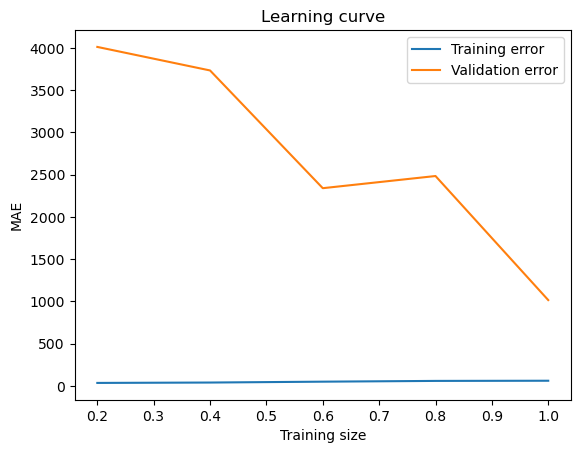

In [71]:
train_sizes = np.linspace(0.2, 1.0, 5)

train_errors, val_errors = [], []

for size in train_sizes:
    size = int(len(X_train)*size)
    xgb.fit(X_train[:size], y_train[:size])
    train_errors.append(mean_absolute_error(y_train[:size], xgb.predict(X_train[:size])))
    val_errors.append(mean_absolute_error(y_val, xgb.predict(X_val)))

plt.plot(train_sizes, train_errors, label="Training error")
plt.plot(train_sizes, val_errors, label="Validation error")
plt.xlabel("Training size")
plt.ylabel("MAE")
plt.legend()
plt.title("Learning curve")
plt.show()


In [72]:
from sklearn.linear_model import Ridge
# Ridge model (regularized linear regression)
ridge = Ridge(alpha=10)  # alpha controls regularization. We can tune later.

# Train on 2012‚Äì2023
ridge.fit(X_train, y_train)

# Predict on 2024 validation data
pred_val_ridge = ridge.predict(X_val)

# Evaluation
mae_ridge = mean_absolute_error(y_val, pred_val_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_val, pred_val_ridge))
r2_ridge = r2_score(y_val, pred_val_ridge)

print("Ridge Regression Performance (Validation 2024)")
print(f"MAE  = {mae_ridge:,.0f} kr")
print(f"RMSE = {rmse_ridge:,.0f} kr")
print(f"R¬≤   = {r2_ridge:.3f}")



Ridge Regression Performance (Validation 2024)
MAE  = 1,263 kr
RMSE = 1,737 kr
R¬≤   = 0.878


In [73]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# Columns in your already one-hot-encoded matrices
num_cols = ["√•r", "rom", "st√∏rrelse_m2"]
cat_cols = [c for c in X_train.columns if c.startswith("Omr√•de_")]

# Scale only numeric columns; pass through dummies unchanged
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols)
    ],
    remainder="passthrough",  # keeps the one-hot columns
    verbose_feature_names_out=False
)

ridge = Ridge(random_state=42)

pipe = Pipeline([
    ("prep", preprocess),
    ("model", ridge),
])

# Log-spaced alpha grid (L2 strength)
param_grid = {
    "model__alpha": np.logspace(-2, 3, 20)  # 0.01 ‚Ä¶ 1000
    # You can optionally try: "model__fit_intercept": [True, False]
}

tscv = TimeSeriesSplit(n_splits=5)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

best_ridge = grid.best_estimator_
print("Best alpha:", grid.best_params_["model__alpha"])
print("CV MAE (train years):", -grid.best_score_)

# Evaluate on 2024
pred_val_ridge = best_ridge.predict(X_val)
mae  = mean_absolute_error(y_val, pred_val_ridge)
rmse = np.sqrt(mean_squared_error(y_val, pred_val_ridge))
r2   = r2_score(y_val, pred_val_ridge)

print("\nüîπ Ridge Regression (tuned) ‚Äî Validation 2024")
print(f"MAE  = {mae:,.0f} kr")
print(f"RMSE = {rmse:,.0f} kr")
print(f"R¬≤   = {r2:.3f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best alpha: 0.01
CV MAE (train years): 882.7245719202386

üîπ Ridge Regression (tuned) ‚Äî Validation 2024
MAE  = 1,250 kr
RMSE = 1,708 kr
R¬≤   = 0.882


In [74]:
# Build evaluation DataFrame for 2024
val_results = X_val.copy()
val_results["Omr√•de"] = long_df.loc[val_filter, "Omr√•de"].values  # restore Omr√•de column
val_results["y_true"] = y_val.values
val_results["y_pred"] = pred_val_ridge
val_results["error"] = val_results["y_pred"] - val_results["y_true"]
val_results["abs_error"] = val_results["error"].abs()

val_results.head()



√•r  rom  st√∏rrelse_m2  Omr√•de_Akershus - n√¶rliggende Oslo kommuner  \
4800  2024    1            15                                        False   
4801  2024    1            20                                        False   
4802  2024    1            30                                        False   
4803  2024    1            40                                        False   
4804  2024    1            50                                        False   

      Omr√•de_Bergen - Bergenhus  Omr√•de_Bergen - √∏vrige bydeler  \
4800                      False                           False   
4801                      False                           False   
4802                      False                           False   
4803                      False                           False   
4804                      False                           False   

      Omr√•de_Kristiansand  \
4800                False   
4801                False   
4802                False   
4803                False   
4804                False   

      Omr√•de_Oslo - Grunerl√∏kka, Gamle Oslo, Sagene, Nordre Aker og Vestre Aker  \
4800                                              False                           
4801                                              False                           
4802                                              False                           
4803                                              False                           
4804                                              False                           

      Omr√•de_Oslo - Sentrum, Frogner, Ullern og St.Hanshaugen  \
4800                                               True         
4801                                               True         
4802                                               True         
4803                                               True         
4804                                               True         

      Omr√•de_Oslo - S√∏ndre Nordstrand, Grorud, Stovner og Alna  ...  \
4800                                              False         ...   
4801                                              False         ...   
4802                                              False         ...   
4803                                              False         ...   
4804                                              False         ...   

      Omr√•de_Tettsteder med 2¬†000 - 19¬†999 innbyggere  Omr√•de_Troms√∏  \
4800                                            False          False   
4801                                            False          False   
4802                                            False          False   
4803                                            False          False   
4804                                            False          False   

      Omr√•de_Trondheim - Lerkendal og Heimdal  \
4800                                    False   
4801                                    False   
4802                                    False   
4803                                    False   
4804                                    False   

      Omr√•de_Trondheim - Midtbyen, √òstbyen og Nedre Elvehavn  \
4800                                              False        
4801                                              False        
4802                                              False        
4803                                              False        
4804                                              False        

      Omr√•de_Utkant Akershus  \
4800                   False   
4801                   False   
4802                   False   
4803                   False   
4804                   False   

                                                Omr√•de   y_true        y_pred  \
4800  Oslo - Sentrum, Frogner, Ullern og St.Hanshaugen  10300.0  12114.298895   
4801  Oslo - Sentrum, Frogner, Ullern og St.Hanshaugen  11100.0  12317.585702   
4802  Oslo - Sentrum, Frogner, Ullern og St.Hanshaugen  12400.0  12724.1

In [75]:
mae_per_area = (
    val_results.groupby("Omr√•de")["abs_error"]
    .mean()
    .sort_values(ascending=False)
)

print("üîπ MAE per area (sorted):")
mae_per_area


üîπ MAE per area (sorted):


Omr√•de
Oslo - Sentrum, Frogner, Ullern og St.Hanshaugen                      2811.555619
Oslo - Grunerl√∏kka, Gamle Oslo, Sagene, Nordre Aker og Vestre Aker    2546.229796
Oslo - √òstensj√∏, Nordstrand og Bjerke                                 2350.988295
Troms√∏                                                                1716.754997
Oslo - S√∏ndre Nordstrand, Grorud, Stovner og Alna                     1612.239996
Akershus - n√¶rliggende Oslo kommuner                                  1541.942339
Bergen - Bergenhus                                                    1227.997333
Trondheim - Midtbyen, √òstbyen og Nedre Elvehavn                       1196.700243
Utkant Akershus                                                       1009.690965
Bergen - √∏vrige bydeler                                                721.083514
Trondheim - Lerkendal og Heimdal                                       698.407639
Tettsteder med 200 - 1¬†999 innbyggere                                  697.196192

In [76]:
bias_per_area = (
    val_results.groupby("Omr√•de")["error"]
    .mean()
    .sort_values()
)

print("Bias per area (mean error):")
bias_per_area


Bias per area (mean error):


Omr√•de
Oslo - Sentrum, Frogner, Ullern og St.Hanshaugen                     -2529.434654
Oslo - Grunerl√∏kka, Gamle Oslo, Sagene, Nordre Aker og Vestre Aker   -2255.955504
Oslo - √òstensj√∏, Nordstrand og Bjerke                                -2183.652314
Troms√∏                                                               -1616.065100
Akershus - n√¶rliggende Oslo kommuner                                 -1372.944537
Oslo - S√∏ndre Nordstrand, Grorud, Stovner og Alna                    -1345.970503
Utkant Akershus                                                       -961.750777
Bergen - Bergenhus                                                    -929.087999
Trondheim - Midtbyen, √òstbyen og Nedre Elvehavn                       -883.055134
Kristiansand                                                          -603.363390
Bergen - √∏vrige bydeler                                               -525.708912
Trondheim - Lerkendal og Heimdal                                      -343.663780


In [77]:
# ‚úÖ Create soft bias correction (e.g. 75% of learned bias)
bias_correction_factor = 0.75  # adjust if needed

bias_adjustment = {
    area: bias * bias_correction_factor
    for area, bias in bias_per_area.items()
}

bias_adjustment


{'Oslo - Sentrum, Frogner, Ullern og St.Hanshaugen': -1897.075990816615,
 'Oslo - Grunerl√∏kka, Gamle Oslo, Sagene, Nordre Aker og Vestre Aker': -1691.9666277953825,
 'Oslo - √òstensj√∏, Nordstrand og Bjerke': -1637.7392353751302,
 'Troms√∏': -1212.0488250554722,
 'Akershus - n√¶rliggende Oslo kommuner': -1029.7084030695391,
 'Oslo - S√∏ndre Nordstrand, Grorud, Stovner og Alna': -1009.477877420394,
 'Utkant Akershus': -721.313082913543,
 'Bergen - Bergenhus': -696.81599948299,
 'Trondheim - Midtbyen, √òstbyen og Nedre Elvehavn': -662.2913503046315,
 'Kristiansand': -452.5225425982221,
 'Bergen - √∏vrige bydeler': -394.28168396017423,
 'Trondheim - Lerkendal og Heimdal': -257.74783508846986,
 'Stavanger': -193.31268292687616,
 'Tettsteder med 20\xa0000 innbyggere eller flere': -187.37548083361415,
 'Tettsteder med 2\xa0000 - 19\xa0999 innbyggere': 133.5777207263318,
 'Tettsteder med 200 - 1\xa0999 innbyggere': 309.43775872506455}

In [78]:
def predict_with_bias(area, X_row):
    base_pred = best_ridge.predict(X_row)[0]
    correction = bias_adjustment.get(area, 0)  # 0 if area not found
    return base_pred - correction  # subtract because bias was negative

# ‚úÖ Example ‚Äî test with one 2024 row
test_row = X_val.iloc[[0]]
test_area = val_results["Omr√•de"].iloc[0]
print("Original prediction:", best_ridge.predict(test_row)[0])
print("Bias corrected prediction:", predict_with_bias(test_area, test_row))


Original prediction: 12114.298894718735
Bias corrected prediction: 14011.37488553535


In [79]:
corrected_preds = []
for i in range(len(X_val)):
    area = val_results["Omr√•de"].iloc[i]
    corrected_preds.append(predict_with_bias(area, X_val.iloc[[i]]))

mae_corrected = mean_absolute_error(y_val, corrected_preds)
print(f"New MAE after bias correction: {mae_corrected:,.0f} kr")


New MAE after bias correction: 866 kr


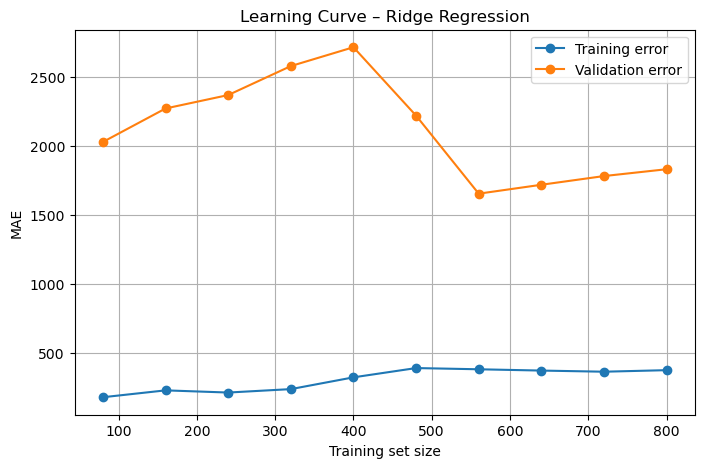

In [80]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_ridge,
    X=X_train,
    y=y_train,
    cv=TimeSeriesSplit(n_splits=5),
    scoring="neg_mean_absolute_error",
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_errors = -train_scores.mean(axis=1)
val_errors   = -val_scores.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_errors, label="Training error", marker='o')
plt.plot(train_sizes, val_errors, label="Validation error", marker='o')
plt.xlabel("Training set size")
plt.ylabel("MAE")
plt.title("Learning Curve ‚Äì Ridge Regression")
plt.legend()
plt.grid(True)
plt.show()


In [81]:

# forutsetter at 'best_ridge' er den tunede Ridge-pipen (GridSearchCV.best_estimator_)
# og at du allerede har:
# - X_train (encodet med samme kolonner som i treningen)
# - bias_adjustment (soft 75% som du nettopp kalkulerte)

joblib.dump(best_ridge, "ridge_model.pkl")
joblib.dump(X_train.columns.tolist(), "feature_columns.pkl")
joblib.dump(list(long_df["Omr√•de"].unique()), "omr√•der.pkl")
joblib.dump(bias_adjustment, "bias_adjustment.pkl")
print("‚úÖ Lagret ridge_model.pkl + feature_columns.pkl + omr√•der.pkl + bias_adjustment.pkl")

# Gyldige inputvalg til appen
rom_per_omr√•de = (
    long_df.groupby("Omr√•de")["rom"]
    .unique()
    .apply(lambda x: sorted(set(int(r) for r in x)))
    .to_dict()
)
m2_per_omr√•de_rom = (
    long_df.groupby(["Omr√•de", "rom"])["st√∏rrelse_m2"]
    .unique()
    .apply(lambda x: sorted(set(int(v) for v in x)))
    .to_dict()
)
joblib.dump(rom_per_omr√•de, "rom_per_omr√•de.pkl")
joblib.dump(m2_per_omr√•de_rom, "m2_per_omr√•de_rom.pkl")
print("‚úÖ Lagret rom_per_omr√•de.pkl og m2_per_omr√•de_rom.pkl")



‚úÖ Lagret ridge_model.pkl + feature_columns.pkl + omr√•der.pkl + bias_adjustment.pkl
‚úÖ Lagret rom_per_omr√•de.pkl og m2_per_omr√•de_rom.pkl


In [82]:
df_23_24 = long_df[long_df["√•r"].isin([2023, 2024])].copy()

area_year_avg = (
    df_23_24.groupby(["Omr√•de", "√•r"])["leiepris"]
    .mean()
    .unstack("√•r")
)

national_growth = (
    (df_23_24[df_23_24["√•r"]==2024]["leiepris"].mean() -
     df_23_24[df_23_24["√•r"]==2023]["leiepris"].mean()) /
     df_23_24[df_23_24["√•r"]==2023]["leiepris"].mean()
)

area_growth = ((area_year_avg[2024] - area_year_avg[2023]) / area_year_avg[2023]).replace([np.inf, -np.inf], np.nan)
area_growth = area_growth.fillna(national_growth)

joblib.dump(area_growth.to_dict(), "area_growth.pkl")
joblib.dump(float(national_growth), "national_growth.pkl")
print(f"‚úÖ Lagret area_growth.pkl (nasjonal vekst: {national_growth*100:.1f}%)")





‚úÖ Lagret area_growth.pkl (nasjonal vekst: 7.4%)


In [83]:

ridge = joblib.load("ridge_model.pkl")
feature_columns = joblib.load("feature_columns.pkl")
bias_adjustment = joblib.load("bias_adjustment.pkl")
area_growth = joblib.load("area_growth.pkl")
national_growth = joblib.load("national_growth.pkl")

def predict_2025_ridge(omraade: str, rom: int, storrelse_m2: float) -> dict:
    # bygg en rad med samme kolonner som under trening
    row = pd.DataFrame([{"√•r": 2025, "rom": int(rom), "st√∏rrelse_m2": float(storrelse_m2)}])
    for c in feature_columns:
        if c.startswith("Omr√•de_"):
            row[c] = 0
    col = f"Omr√•de_{omraade}"
    if col in feature_columns:
        row[col] = 1
    row = row.reindex(columns=feature_columns, fill_value=0)

    base = float(ridge.predict(row)[0])
    bias = float(bias_adjustment.get(omraade, 0.0))     # dine verdier er negative i dyre omr√•der
    corrected = base - bias                             # hever pris i underestimerte omr√•der

    g = float(area_growth.get(omraade, national_growth))
    pred_2025 = corrected * (1.0 + g)

    return {
        "base": base,
        "bias_applied": -bias,   # rapporter som + hvis det √∏ker
        "growth": g,
        "pred_2025": pred_2025
    }

# liten sanity test:
test_area = long_df["Omr√•de"].iloc[0]
print(predict_2025_ridge(test_area, rom=2, storrelse_m2=50))




{'base': 15038.032202473976, 'bias_applied': 1897.075990816615, 'growth': 0.08390373150805917, 'pred_2025': 18356.026964200377}
